# Smart Charging Using Reinforcement Learning

In [ ]:
import numpy as np
from gym import Env
from gym.spaces import Box, Discrete
import random

In [297]:
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
import numpy as np
#%matplotlib inline

In [298]:
# Define constants
output_size = 4 # Number of charging rates (zero, low, medium, high)

In [299]:
class EVChargingState:
    def __init__(self, battery_level, time_index):
        self.battery_level = battery_level
        self.time_index = time_index

    # convert state to tensor for feeding into neural network
    def as_tensor(self):
        return tf.convert_to_tensor([self.battery_level, self.time_index], dtype=tf.float32)

In [300]:
class QNetwork(tf.keras.Model):
    def __init__(self, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = tf.keras.layers.Dense(64, activation='relu')
        self.fc2 = tf.keras.layers.Dense(32, activation='relu')
        self.fc3 = tf.keras.layers.Dense(output_size, activation=None)

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

### Electric Charging Environment

In [301]:
def calculate_reward(time_coefficient, charging_rate):
    recharging_cost = time_coefficient*np.exp(charging_rate)
    reward = -recharging_cost
    return reward

In [302]:
class EVChargingEnvironment:
    def __init__(self, time_intervals, charging_rates, time_coefficients, battery_capacity, energy_demand_mu, energy_demand_sigma):
        self.time_intervals = time_intervals
        self.charging_rates = charging_rates
        self.time_coefficients = time_coefficients
        self.battery_capacity = battery_capacity
        self.energy_demand_mu = energy_demand_mu
        self.energy_demand_sigma = energy_demand_sigma
        
        self.current_time_index = 0
        self.current_battery_level = battery_capacity
        
    def reset(self):
        self.current_time_index = 0

        # Get energy demand of new episode
        self.energy_demand = np.random.normal(self.energy_demand_mu, self.energy_demand_sigma)

        return EVChargingState(self.current_battery_level, self.current_time_index)
    
    def step(self, action):
        
        # Ensure valid action
        if action < 0 or action >= len(self.charging_rates):
            raise ValueError("Invalid action")
        
        # Get current time coefficient and charging rate
        time_coefficient = self.time_coefficients[self.current_time_index]
        charging_rate = self.charging_rates[action]
        
        # Calculate reward
        reward = calculate_reward(time_coefficient, charging_rate)

        # Update battery level
        new_battery_level = self.current_battery_level + charging_rate
        self.current_battery_level = max(0, min(new_battery_level, self.battery_capacity))

        # Update time index
        self.current_time_index = (self.current_time_index + 1) % len(self.time_intervals)
        
        # Check if simulation is complete
        done = self.current_time_index == 0

        if done:
            self.current_battery_level = self.current_battery_level - self.energy_demand
            #print(self.current_battery_level)
            
            # Set penalty if battery level is too low for energy demand
            if self.current_battery_level < 0:
                reward -= 10000.0
                self.current_battery_level = 0 # Set Battery Level to Zero
        
        next_state = EVChargingState(self.current_battery_level, self.current_time_index)
        return next_state, reward, done


### Markov Decision Process with Deep Q-Network

In [3]:
learning_rate = 0.001
discount_factor = 0.95
num_episodes = 1000
target_update_freq = 10

#define constants
output_size = 4 # Number of charging rates (zero, low, medium, high)
time_intervals = [0, 1, 2, 3, 4, 5, 6, 7] # from 2pm to 4pm every 15 minutes
charging_rates = [0, 1.75, 3.5, 5.5] # normalized to 1
# Energy prices increase with increasing time of day
time_coefficients = [0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1]
battery_capacity = 100 # in kWh
energy_demand_mu = 30 # in kWh
energy_demand_sigma = 5 # in kWh

epsilons = [0, 0.01, 0.1, 0.3]

cumulative_rewards_lists = []
remaining_energy_lists = []

for epsilon in epsilons:

    # Create Q-network and target network
    q_network = QNetwork(output_size)
    target_network = QNetwork(output_size)
    target_network.set_weights(q_network.get_weights())
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Create Instance of environment
    env = EVChargingEnvironment(time_intervals, charging_rates, time_coefficients, battery_capacity, energy_demand_mu, energy_demand_sigma)

    cumulative_rewards = []
    remaining_energy = []
    # Training loop
    for episode in range(num_episodes):
        #print("NEW EPISODE " + str(episode))
        state = env.reset()    
        done = False
        actions = []
        cumulative_reward = 0

        while not done:
            state_tensor = tf.convert_to_tensor(state.as_tensor())
            state_tensor = tf.expand_dims(state_tensor, axis=0)

            if state.battery_level >= env.battery_capacity:
                action = 0 # No loading if capacity is reached
            elif np.random.rand() < epsilon:
                action = np.random.choice(output_size)
            else:
                q_values = q_network(state_tensor)
                action = np.argmax(q_values.numpy())
            actions.append(action)
            
            # Perform action in the environment
            next_state, reward, done = env.step(action)
            cumulative_reward += reward
            next_state_tensor = tf.convert_to_tensor(next_state.as_tensor())
            next_state_tensor = tf.expand_dims(next_state_tensor, axis=0)
            
            # Calculate target and loss
            target_q_values = target_network(next_state_tensor)
            max_target_q = np.max(target_q_values.numpy())

            target = reward + discount_factor * max_target_q
            target = tf.constant(target, dtype=tf.float32)
            target = tf.reshape(target, (1, 1))
            
            with tf.GradientTape() as tape:
                # Given q_values, action, and target
                q_values = q_network(state_tensor)
                current_q = q_values[0, action]
                current_q = tf.reshape(current_q, (1, 1))

                loss = tf.losses.mean_squared_error(target, current_q)
            
                # Update Q-network
                gradients = tape.gradient(loss, q_network.trainable_variables)
                optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
            
            # Update target network periodically
            if episode % target_update_freq == 0:
                target_network.set_weights(q_network.get_weights())
            
            state = next_state
        
        remaining_energy.append(state.battery_level)
        cumulative_rewards.append(cumulative_reward)

    cumulative_rewards_lists.append(cumulative_rewards)
    remaining_energy_lists.append(remaining_energy)


NameError: name 'QNetwork' is not defined

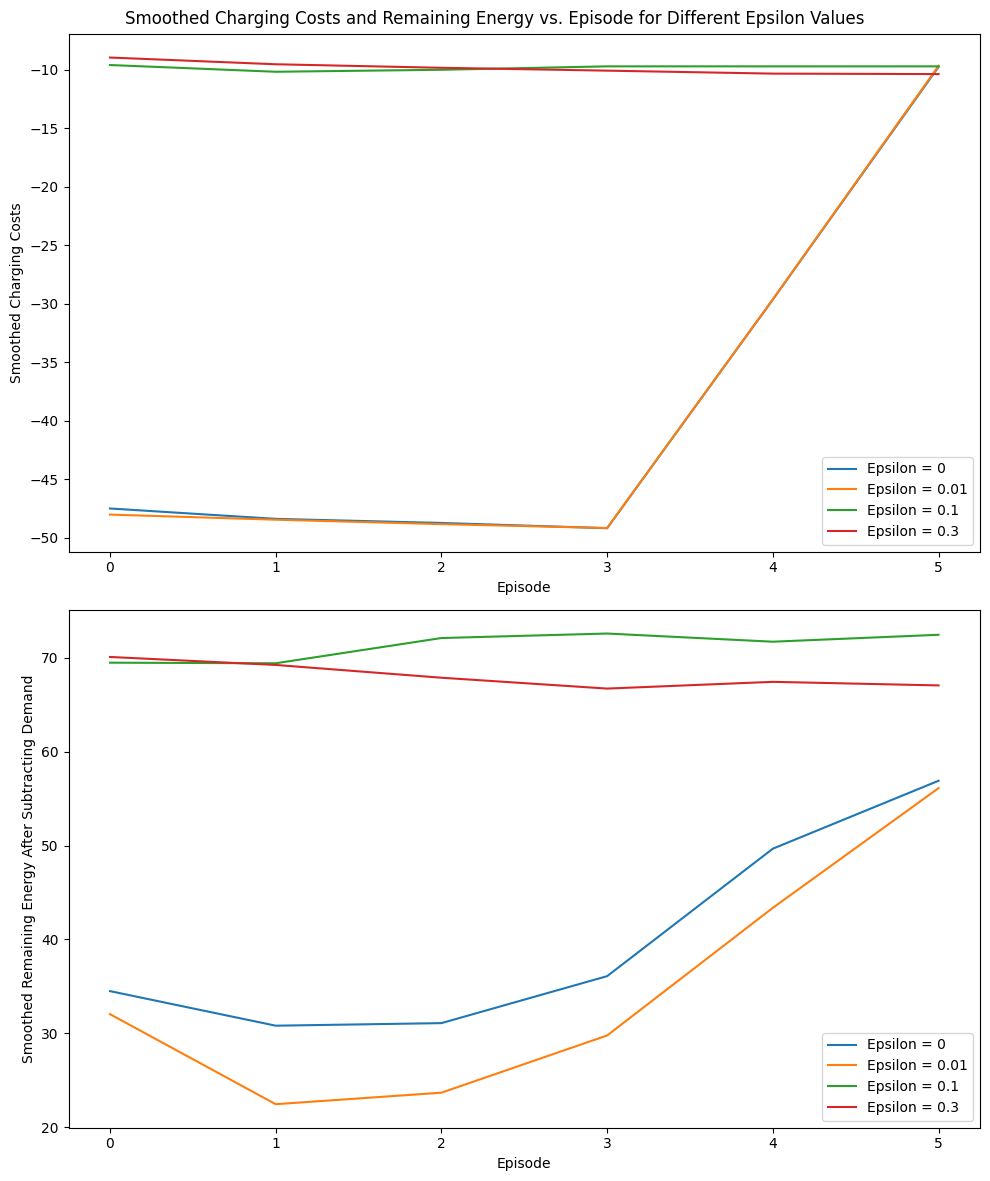

In [347]:
# Calculate moving averages
moving_avg_window = 5  # Adjust this window size as needed

moving_avg_cumulative_rewards = [
    np.convolve(cc, np.ones(moving_avg_window), 'valid') / moving_avg_window
    for cc in cumulative_rewards_lists
]

moving_avg_remaining_energy = [
    np.convolve(re, np.ones(moving_avg_window), 'valid') / moving_avg_window
    for re in remaining_energy_lists
]

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
fig.suptitle('Smoothed Charging Costs and Remaining Energy vs. Episode for Different Epsilon Values')

for i, epsilon in enumerate(epsilons):
    axs[0].plot(moving_avg_cumulative_rewards[i], label=f'Epsilon = {epsilon}')
    axs[1].plot(moving_avg_remaining_energy[i], label=f'Epsilon = {epsilon}')

axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Smoothed Charging Costs')
axs[0].legend()

axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Smoothed Remaining Energy After Subtracting Demand')
axs[1].legend()

plt.tight_layout()
plt.show()
